## Data Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

In [3]:
path = kagglehub.dataset_download("xfkzujqjvx97n/football-datasets")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Minmin.Yuan\.cache\kagglehub\datasets\xfkzujqjvx97n\football-datasets\versions\2


In [4]:
print(os.listdir(path))

['player_injuries', 'player_latest_market_value', 'player_market_value', 'player_national_performances', 'player_performances', 'player_profiles', 'player_teammates_played_with', 'team_children', 'team_competitions_seasons', 'team_details', 'transfer_history']


### Load Relevant Tables

In [5]:
injuries_file = os.path.join(path, "player_injuries", "player_injuries.csv")
performance_file = os.path.join(path,"player_performances","player_performances.csv")
profile_file = os.path.join(path, "player_profiles","player_profiles.csv")

In [6]:
injuries = pd.read_csv(injuries_file)
print(injuries.head(5))

   player_id season_name     injury_reason   from_date    end_date  \
0         10       15/16       Hand injury  2016-04-19  2016-04-29   
1         10       15/16    Thigh problems  2015-12-18  2015-12-31   
2         10       15/16   Capsular injury  2015-11-11  2015-11-21   
3         10       15/16              Rest  2015-11-04  2015-11-06   
4         10       15/16  Hamstring injury  2015-08-20  2015-10-08   

   days_missed  games_missed  
0         11.0             2  
1         14.0             1  
2         11.0             0  
3          3.0             1  
4         50.0            10  


In [7]:
performance = pd.read_csv(performance_file)
print(performance.head(5))

   player_id season_name competition_id   competition_name  team_id  \
0          1       08/09           OBLG  NOFV-Oberliga Süd     4825   
1          1       07/08             RS   Regionalliga Süd     1526   
2          1       06/07             L2      2. Bundesliga      996   
3          1       06/07            DFB          DFB-Pokal      996   
4          1       05/06             L2      2. Bundesliga       66   

                     team_name  nb_in_group  nb_on_pitch  goals  assists  \
0                 FC Eilenburg            9            9    0.0        0   
1  FSV Ludwigshafen Oggersheim           22           22    1.0        0   
2                  TuS Koblenz           10            4    0.0        0   
3                  TuS Koblenz            1            0    0.0        0   
4           SpVgg Unterhaching           26           14    1.0        1   

   own_goals  subed_in  subed_out  yellow_cards  second_yellow_cards  \
0          0         0          2           

In [8]:
profile = pd.read_csv(profile_file)
print(profile.head(5))

   player_id     player_slug             player_name  \
0          1    silvio-adzic        Silvio Adzic (1)   
1     100011   everton-silva  Éverton Silva (100011)   
2         10  miroslav-klose     Miroslav Klose (10)   
3      10001   john-thompson   John Thompson (10001)   
4     100001   carlos-auzqui  Carlos Auzqui (100001)   

                                    player_image_url  \
0  https://img.a.transfermarkt.technology/portrai...   
1  https://img.a.transfermarkt.technology/portrai...   
2  https://img.a.transfermarkt.technology/portrai...   
3  https://img.a.transfermarkt.technology/portrai...   
4  https://img.a.transfermarkt.technology/portrai...   

            name_in_home_country date_of_birth      place_of_birth  \
0                            NaN    1980-09-23           Grünstadt   
1  Éverton José Modesto da Silva    1988-08-04  São João de Meriti   
2           Miroslav Josef Klose    1978-06-09               Opole   
3             John Paul Thompson    1981-10-12

C:\Users\Minmin.Yuan\AppData\Local\Temp\ipykernel_34292\555434735.py:1: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  profile = pd.read_csv(profile_file)


### Clean Data Format

In [9]:
print(injuries.groupby("season_name")["season_name"].count()) #season_name has inconsistent formats

season_name
00/01        218
01/02        250
02/03        253
03/04        277
04/05        348
05/06        337
06/07        397
07/08       1386
08/09       1993
09/10       1772
10/11       2417
11/12       2835
12/13       3399
13/14       4145
14/15       4689
15/16       5816
16/17       7596
17/18       8734
18/19      10463
19/20      10372
1909/10        5
1910/11        2
20/21      14058
21/22      14885
22/23      14296
23/24      14483
24/25      15102
25/26       2108
73/74          2
74/75          3
75/76          2
80/81          3
81/82          1
82/83          1
83/84          3
89/90          5
90/91          3
91/92          5
92/93          6
93/94         22
94/95         23
95/96         47
96/97         65
97/98         84
98/99        124
99/00        160
Name: season_name, dtype: int64


In [10]:
print(injuries.groupby("injury_reason")["injury_reason"].count()) #349 types of injury reasons

injury_reason
Abdominal muscle strain         196
Abdominal problems               83
Achilles heel problems          113
Achilles tendon contusion        54
Achilles tendon irritation      173
                              ...  
stroke                            3
surgery                         402
traffic accident                 57
tuberculosis                      3
unknown injury                27028
Name: injury_reason, Length: 349, dtype: int64


In [11]:
print(performance["season_name"].value_counts())  #season_name has inconsistent formats

season_name
22/23    106476
23/24    105401
21/22    104402
24/25    103828
20/21     89959
          ...  
65/66         1
1960          1
61/62         1
60/61         1
1984          1
Name: count, Length: 102, dtype: int64


In [12]:
import re

def _two_digit_to_year(two: int, pivot: int = 49) -> int:
    """
    Map a 2-digit year to a full year using a pivot:
    - two <= pivot -> 2000s (e.g., 25 -> 2025)
    - two > pivot  -> 1900s (e.g., 73 -> 1973)
    Default pivot=49 covers modern football datasets well.
    """
    return 2000 + two if two <= pivot else 1900 + two

def season_name_to_start_year(season_str: str) -> int:
    """
    Return the START YEAR for a season string.

    Supported formats:
      - 'YY/YY'       -> e.g., '22/23' -> 2022
      - 'YYYY/YY'     -> e.g., '1909/10' -> 1909 (rollover handled)
      - 'YY/YYYY'     -> e.g., '99/2000' -> 1999
      - 'YYYY/YYYY'   -> e.g., '2023/2024' -> 2023
      - 'YYYY'        -> e.g., '1984' -> 1984 (treated as single-year season)
      - 'YY'          -> e.g., '84' -> 1984 based on pivot

    Notes:
    - Century rollover: '99/00' -> start 1999, end 2000 (start_year=1999).
    - Whitespace is ignored.
    - Raises ValueError for unsupported formats.
    """
    if season_str is None:
        raise ValueError("season_str is None")

    s = str(season_str).strip()
    if not s:
        raise ValueError("Empty season string")

    if "/" in s:
        left, right = [p.strip() for p in s.split("/", 1)]

        # YYYY/YYYY
        if re.fullmatch(r"\d{4}", left) and re.fullmatch(r"\d{4}", right):
            return int(left)

        # YYYY/YY
        if re.fullmatch(r"\d{4}", left) and re.fullmatch(r"\d{2}", right):
            return int(left)

        # YY/YYYY
        if re.fullmatch(r"\d{2}", left) and re.fullmatch(r"\d{4}", right):
            end_year = int(right)
            end_two = end_year % 100
            start_two = int(left)
            # If start_two > end_two, the start is in the previous century
            start_century = (end_year - end_two) - (100 if start_two > end_two else 0)
            return start_century + start_two

        # YY/YY
        if re.fullmatch(r"\d{2}", left) and re.fullmatch(r"\d{2}", right):
            return _two_digit_to_year(int(left))

        raise ValueError(f"Unrecognized season format: {season_str}")

    # Single token (no slash)
    # YYYY
    if re.fullmatch(r"\d{4}", s):
        return int(s)

    # YY
    if re.fullmatch(r"\d{2}", s):
        return _two_digit_to_year(int(s))

    raise ValueError(f"Invalid season format: {season_str}")


In [13]:
def safe_start_year(s):
    try:
        return season_name_to_start_year(s)
    except Exception:
        return np.nan

In [14]:
performance["season_id"] = performance["season_name"].apply(safe_start_year)
performance = performance.dropna(subset=["season_id"])
performance["season_id"] = performance["season_id"].astype(int)

# performance_2000_2025 
performance_2000_2025 = performance.loc[performance["season_id"].between(2000, 2025)].copy()

In [15]:
print(performance_2000_2025["season_id"].value_counts().sort_index().head())
print(performance_2000_2025.shape)

season_id
2000    16649
2001    19614
2002    22052
2003    25532
2004    28682
Name: count, dtype: int64
(1815114, 21)


In [16]:
injuries["season_id"] = injuries["season_name"].apply(safe_start_year)
injuries = injuries.dropna(subset=["season_id"])
injuries["season_id"] = injuries["season_id"].astype(int)

# Filter to 2000–2025
injuries_2000_2025 = injuries.loc[injuries["season_id"].between(2000, 2025)].copy()

print(injuries_2000_2025["season_id"].value_counts().sort_index().head())
print(injuries_2000_2025.shape)

season_id
2000    218
2001    250
2002    253
2003    277
2004    348
Name: count, dtype: int64
(142629, 8)


In [17]:
injuries_2000_2025["from_date"] = pd.to_datetime(injuries_2000_2025["from_date"])
injuries_2000_2025["end_date"] = pd.to_datetime(injuries_2000_2025["end_date"])

In [18]:
injuries_2000_2025.describe()

,player_id,from_date,end_date,days_missed,games_missed,season_id
count,1.426290e+05,142607,141106,142607.000000,142629.000000,142629.000000
mean,2.539123e+05,2019-08-20 08:41:38.166288896,2019-09-16 19:11:38.691763712,51.673992,6.621921,2018.674211
min,2.000000e+00,1996-04-29 00:00:00,1996-05-19 00:00:00,1.000000,0.000000,2000.000000
25%,6.190600e+04,2017-02-24 00:00:00,2017-03-25 00:00:00,10.000000,1.000000,2016.000000
50%,1.894520e+05,2020-10-30 00:00:00,2020-11-21 00:00:00,22.000000,3.000000,2020.000000
75%,3.827740e+05,2023-03-07 00:00:00,2023-03-31 00:00:00,53.000000,7.000000,2022.000000
max,1.396965e+06,2025-12-22 00:00:00,2026-09-01 00:00:00,8655.000000,208.000000,2025.000000
std,2.318904e+05,NaN,NaN,104.384208,9.448434,4.603369


In [19]:
# Note:There are some inconsistencies in `from_date` and `to_date` columns in injuries_2000_2025 dataframe, with minimum values going back to 1996. 
# To ensure data relevance and accuracy, we will **remove rows where `from_date` is before the year 2000**.

injuries_2000_2025 = injuries_2000_2025[
    injuries_2000_2025["from_date"].between("2000-01-01", "2025-12-31")
]

In [20]:
profile["date_of_birth"] = pd.to_datetime(profile["date_of_birth"])

In [21]:
profile.isna().sum()

player_id                              0
player_slug                            0
player_name                          520
player_image_url                       0
name_in_home_country               43018
date_of_birth                       1006
place_of_birth                     16633
country_of_birth                   16645
height                                 4
citizenship                           57
is_eu                                  0
position                               2
main_position                          2
foot                               23488
current_club_id                        0
current_club_name                      0
joined                              3382
contract_expires                   54005
outfitter                          86713
social_media_url                   72334
player_agent_id                    54614
player_agent_name                  49791
contract_option                    89100
date_of_last_contract_extension    84308
on_loan_from_clu

In [22]:
profile.describe()

,player_id,date_of_birth,height,current_club_id,player_agent_id,on_loan_from_club_id
count,9.267100e+04,91665,92667.000000,92671.000000,38057.000000,3758.000000
mean,4.822020e+05,1994-08-31 03:55:43.151693568,144.619908,17268.764835,5654.314160,14245.704364
min,1.000000e+00,1952-02-13 00:00:00,0.000000,1.000000,1.000000,2.000000
25%,1.214005e+05,1988-06-23 00:00:00,171.000000,123.000000,2325.000000,738.000000
50%,4.021140e+05,1996-06-03 00:00:00,180.000000,1533.000000,4906.000000,3901.000000
75%,7.989040e+05,2002-03-05 00:00:00,185.000000,22177.000000,8598.000000,14926.000000
max,1.459023e+06,2010-10-12 00:00:00,210.000000,134553.000000,15015.000000,132806.000000
std,3.894922e+05,NaN,73.368611,28780.506345,4038.521566,23763.128575


In [23]:
profile["height"].value_counts()

height
0.0      18867
180.0     5982
185.0     4793
178.0     4751
183.0     4636
175.0     3903
182.0     3701
188.0     3635
184.0     3446
186.0     3369
187.0     3009
181.0     2901
177.0     2792
190.0     2648
176.0     2614
179.0     2508
173.0     2098
174.0     2032
170.0     1808
189.0     1792
191.0     1653
172.0     1546
193.0     1240
192.0     1232
171.0      926
194.0      756
168.0      699
169.0      578
195.0      576
196.0      481
167.0      320
165.0      259
197.0      236
198.0      216
166.0      177
164.0       92
163.0       67
201.0       56
199.0       52
200.0       43
162.0       37
202.0       30
160.0       29
203.0       19
161.0       17
204.0       12
205.0        6
158.0        6
159.0        5
206.0        4
155.0        3
154.0        2
210.0        1
208.0        1
2.0          1
207.0        1
153.0        1
156.0        1
152.0        1
Name: count, dtype: int64

### Select and Reduce Features

#### profile (player_level)

In [24]:
# Keep height for now because we want to check correlation between height and injury risk first before deciding to drop or compute missing values.
profile_df = profile[["player_id","date_of_birth", "position", "height"]]

In [25]:
profile_df['height'] = profile_df['height'].replace(0, np.nan)

C:\Users\Minmin.Yuan\AppData\Local\Temp\ipykernel_34292\3771051230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_df['height'] = profile_df['height'].replace(0, np.nan)


In [26]:
profile_df.isna().sum()

player_id            0
date_of_birth     1006
position             2
height           18871
dtype: int64

In [27]:
#Handle missimg values
profile_df = profile_df.dropna(subset=["date_of_birth"])
profile_df = profile_df.dropna(subset=["position"])

#### performance (anchor table)

In [28]:
performance_2000_2025.isna().sum()

player_id                    0
season_name                  0
competition_id               0
competition_name             0
team_id                      0
team_name                    0
nb_in_group                  0
nb_on_pitch                  0
goals                   132180
assists                      0
own_goals                    0
subed_in                     0
subed_out                    0
yellow_cards                 0
second_yellow_cards          0
direct_red_cards             0
penalty_goals                0
minutes_played         1133346
goals_conceded               0
clean_sheets                 0
season_id                    0
dtype: int64

In [29]:
len(performance_2000_2025)

1815114

In [30]:
performance_df = performance_2000_2025[["player_id", "season_id","nb_in_group","nb_on_pitch","goals","assists","subed_in","subed_out","yellow_cards"]]

In [31]:
performance_df = performance_df [performance_df["nb_on_pitch"]>0] #Keep only players who were actually exposed to injury risk

In [32]:
performance_df["goals"] = performance_df["goals"].fillna(0)

#### Aggregate injuries

In [33]:
injuries_2000_2025.isna().sum()

player_id           0
season_name         0
injury_reason       0
from_date           0
end_date         1523
days_missed         0
games_missed        0
season_id           0
dtype: int64

In [34]:
injury_agg = (injuries_2000_2025.groupby(["player_id","season_id"])
    .agg(injuries_count=("injury_reason","count"),total_days_missed=("days_missed","sum")) .reset_index())

#### Merge injury data

In [35]:
df = performance_df.merge(
    injury_agg, 
    on = ["player_id","season_id"],
    how = "left")

In [36]:
df[["injuries_count","total_days_missed"]] = (df[["injuries_count","total_days_missed"]].fillna(0))

In [37]:
df.isna().sum()

player_id            0
season_id            0
nb_in_group          0
nb_on_pitch          0
goals                0
assists              0
subed_in             0
subed_out            0
yellow_cards         0
injuries_count       0
total_days_missed    0
dtype: int64

#### Add player profile features

In [38]:
df = df.merge(profile_df, on='player_id', how='inner')

df['age'] = df['season_id'] - df['date_of_birth'].dt.year

#### Add workload proxies and historical injury features

In [39]:
df['pct_on_pitch'] = df['nb_on_pitch'] / df['nb_in_group'].replace(0,1)
df['starts_proxy'] = df['nb_on_pitch'] - df['subed_in']

In [40]:
df = df.sort_values(['player_id','season_id'])

df['injuries_prev'] = (
    df.groupby('player_id')['injuries_count']
      .shift(1).fillna(0)
)

df['days_missed_prev'] = (
    df.groupby('player_id')['total_days_missed']
      .shift(1).fillna(0)
)

#### Define Prediction Target

In [41]:
df['injured_next_season'] = (
    df.groupby('player_id')['injuries_count']
      .shift(-1)
      .fillna(0)
      .gt(0)
      .astype(int)
)

In [42]:
df = df[~df['injured_next_season'].isna()]

#### Correlation between height and target

In [43]:
from scipy.stats import pointbiserialr

# Drop rows missing either height 
tmp = df.dropna(subset=['height'])

# Compute point-biserial correlation
corr, pval = pointbiserialr(tmp['injured_next_season'], tmp['height'])
print(f"Point-biserial correlation: {corr:.3f}, p-value: {pval:.3g}")

Point-biserial correlation: 0.030, p-value: 2.87e-292


In [44]:
import statsmodels.api as sm
import patsy as pt

# Example: logistic regression with interaction
formula = 'injured_next_season ~ height * C(position) + age'
y, X = pt.dmatrices(formula, tmp, return_type='dataframe')
logit = sm.Logit(y, X).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.423605
         Iterations 30
                            Logit Regression Results                           
Dep. Variable:     injured_next_season   No. Observations:              1510278
Model:                           Logit   Df Residuals:                  1510243
Method:                            MLE   Df Model:                           34
Date:                 Tue, 13 Jan 2026   Pseudo R-squ.:                 0.01313
Time:                         10:18:48   Log-Likelihood:            -6.3976e+05
converged:                        True   LL-Null:                   -6.4828e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept        

Main effect of height is not significant (β ≈ -0.021, p ≈ 0.45) → height alone doesn’t predict much.
Height × position interactions show signal for certain roles:

Defender (β≈+0.1185, p=0.002), Centre-Back (β≈+0.0644, p=0.02),
Goalkeeper (β≈+0.0798, p=0.004), Defensive Midfield (β≈+0.0565, p=0.042),
Right Midfield (β≈+0.0678, p=0.015)
Interpretation: Taller players in those positions have higher odds of being injured next season, controlling for other covariates.


Age is extremely strong (β≈+0.0334 per year, p≪0.001), ~+3.4% odds per year; over 10 years → ~+40% odds.

Since height interacts strongly with position (especially for defenders and goalkeepers), we decide to keep height. Because about 21% of height is missing, we will impute height by position group (median), because height varies by position (e.g., goalkeepers are taller than wingers).

In [45]:
# Group-wise median imputation by position
df['height'] = df.groupby('position')['height'].transform(lambda x: x.fillna(x.median()))

In [46]:
df.head(5)

,player_id,season_id,nb_in_group,nb_on_pitch,goals,assists,subed_in,subed_out,yellow_cards,injuries_count,total_days_missed,date_of_birth,position,height,age,pct_on_pitch,starts_proxy,injuries_prev,days_missed_prev,injured_next_season
14,1,2000,14,6,1.0,2,5,1,0,0.0,0.0,1980-09-23,Attack - Right Winger,177.0,20,0.428571,1,0.0,0.0,0
15,1,2000,20,20,15.0,0,0,5,0,0.0,0.0,1980-09-23,Attack - Right Winger,177.0,20,1.000000,20,0.0,0.0,0
16,1,2000,10,1,0.0,0,0,0,0,0.0,0.0,1980-09-23,Attack - Right Winger,177.0,20,0.100000,1,0.0,0.0,0
17,1,2000,1,1,0.0,0,0,0,1,0.0,0.0,1980-09-23,Attack - Right Winger,177.0,20,1.000000,1,0.0,0.0,0
12,1,2001,28,28,9.0,0,1,5,5,0.0,0.0,1980-09-23,Attack - Right Winger,177.0,21,1.000000,27,0.0,0.0,0


In [47]:
model_df = df.copy()

In [48]:
position_groups = {
    'Attack - Centre-Forward': 'Attack',
    'Attack - Left Winger': 'Attack',
    'Attack - Right Winger': 'Attack',
    'Attack - Second Striker': 'Attack',
    'Attack':"Attack",
    'Midfield': 'Midfield',
    'Midfield - Attacking Midfield': 'Midfield',
    'Midfield - Central Midfield': 'Midfield',
    'Midfield - Defensive Midfield': 'Midfield',
    'Midfield - Left Midfield': 'Midfield',
    'Midfield - Right Midfield': 'Midfield',
    'Defender': 'Defense',
    'Defender - Centre-Back': 'Defense',
    'Defender - Left-Back': 'Defense',
    'Defender - Right-Back': 'Defense',
    'Defender - Sweeper': 'Defense',
    'Goalkeeper': 'Goalkeeper'
}

model_df['position_group'] = model_df['position'].map(position_groups)

In [49]:
print(model_df['position_group'].value_counts())

position_group
Defense       535163
Midfield      504893
Attack        459445
Goalkeeper    131801
Name: count, dtype: int64


In [50]:
drop_cols = [
    "player_id", 
    "nb_in_group", 
    "subed_in", 
    "subed_out", 
    "date_of_birth", 
    "position"  # raw position, now replaced by position_group
]

model_df = model_df.drop(columns=drop_cols)

In [51]:
print(model_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1631302 entries, 14 to 201862
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   season_id            1631302 non-null  int64  
 1   nb_on_pitch          1631302 non-null  int64  
 2   goals                1631302 non-null  float64
 3   assists              1631302 non-null  int64  
 4   yellow_cards         1631302 non-null  int64  
 5   injuries_count       1631302 non-null  float64
 6   total_days_missed    1631302 non-null  float64
 7   height               1631302 non-null  float64
 8   age                  1631302 non-null  int64  
 9   pct_on_pitch         1631302 non-null  float64
 10  starts_proxy         1631302 non-null  int64  
 11  injuries_prev        1631302 non-null  float64
 12  days_missed_prev     1631302 non-null  float64
 13  injured_next_season  1631302 non-null  int64  
 14  position_group       1631302 non-null  object 
dtypes: 

### Exploratory Data Analysis

In [52]:
categorical = ["position_group"]
numerical = ["nb_on_pitch","goals","assists", "yellow_cards","injuries_count","total_days_missed",
             "height","age", "pct_on_pitch", "starts_proxy", "injuries_prev","days_missed_prev"]

In [53]:
print(model_df["injured_next_season"].value_counts(normalize=True))

injured_next_season
0    0.852045
1    0.147955
Name: proportion, dtype: float64


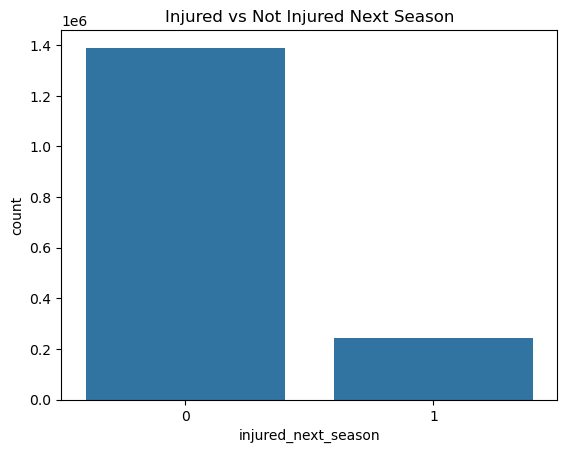

In [54]:
sns.countplot(data=model_df, x= "injured_next_season")
plt.title("Injured vs Not Injured Next Season")
plt.show()

#### Univariate EDA for numerical features

In [55]:
target = 'injured_next_season'

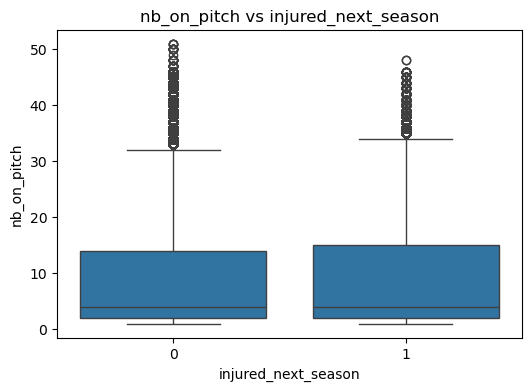

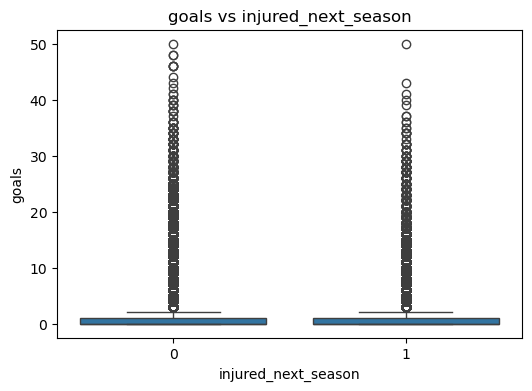

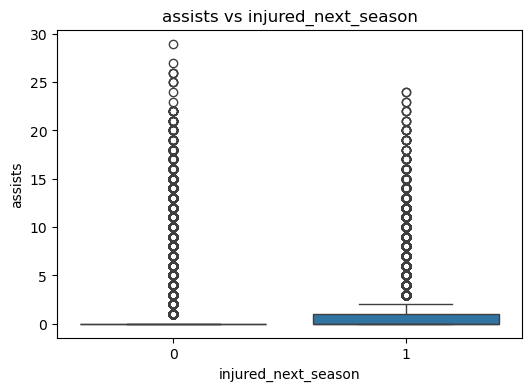

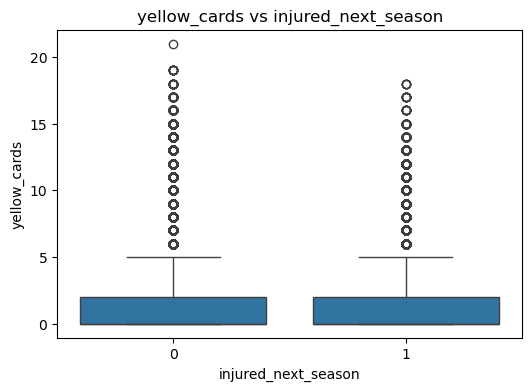

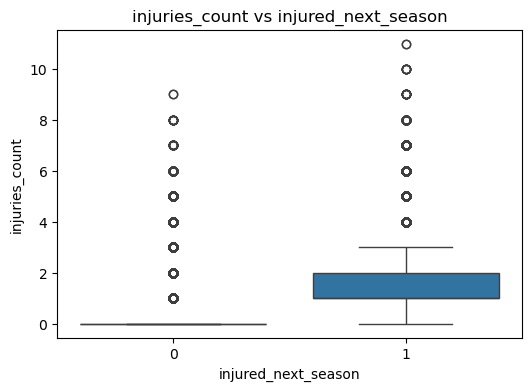

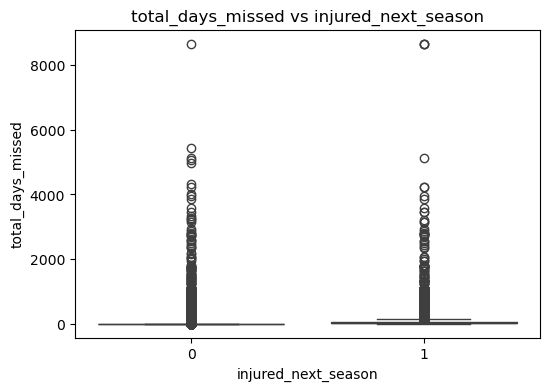

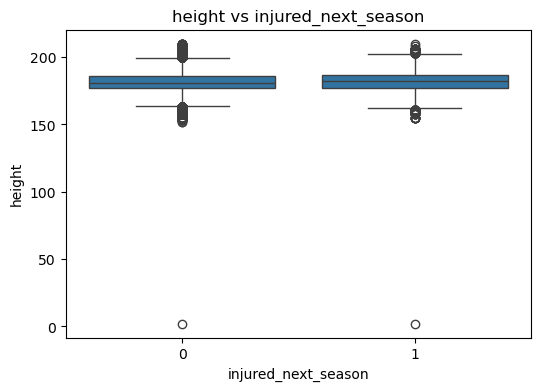

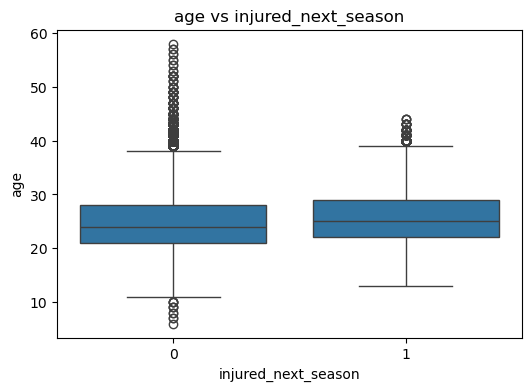

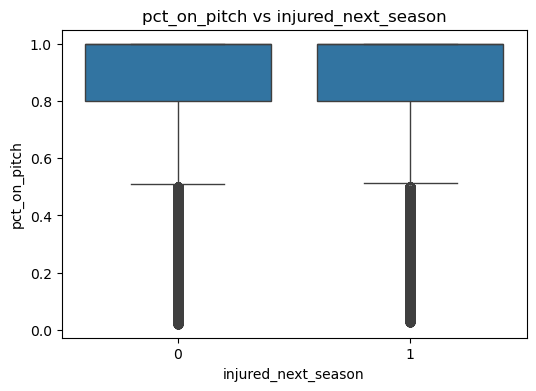

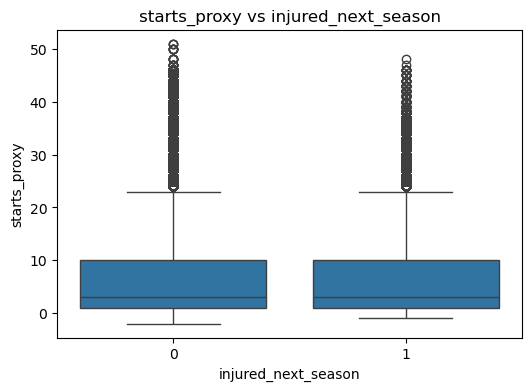

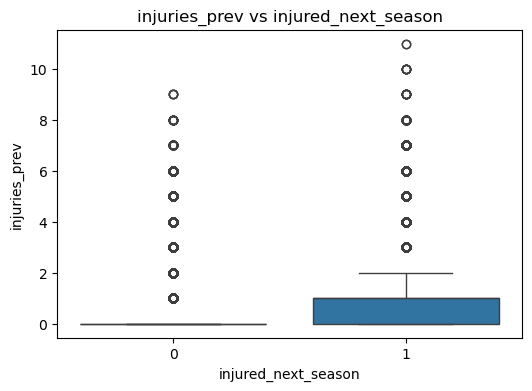

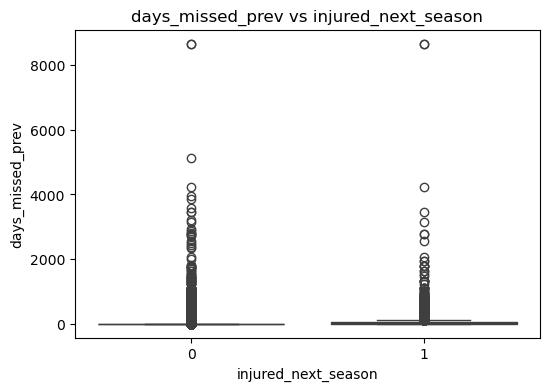

In [56]:
for col in numerical:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target, y=col, data=model_df)
    plt.title(f"{col} vs {target}")
    plt.show()

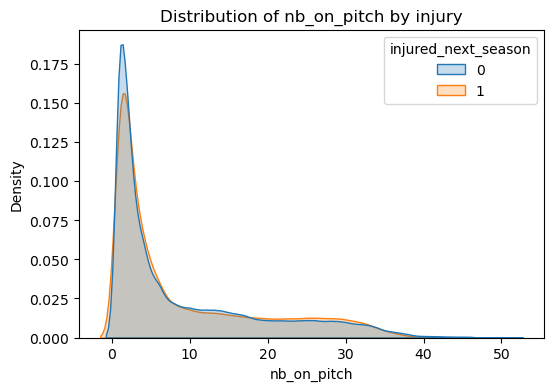

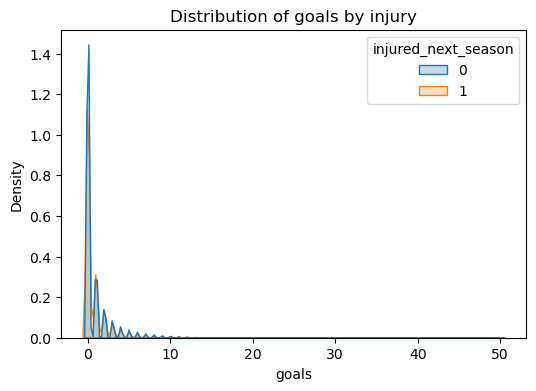

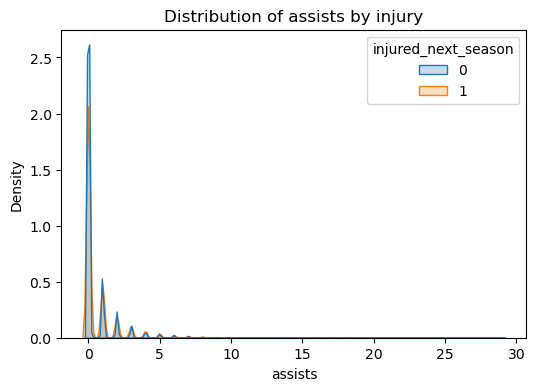

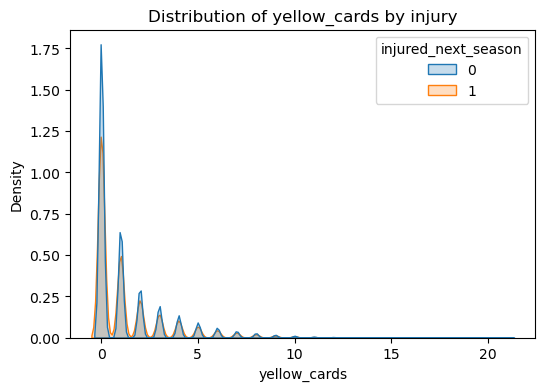

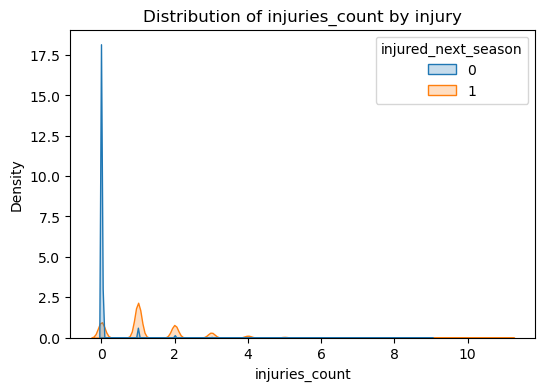

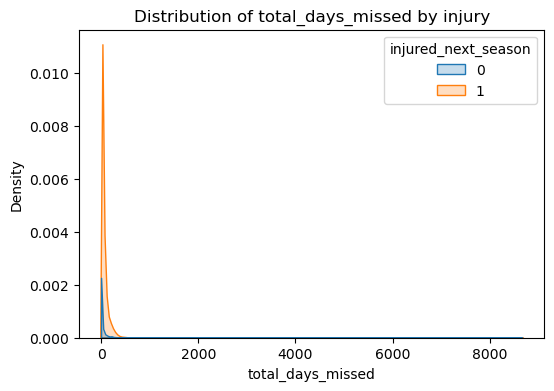

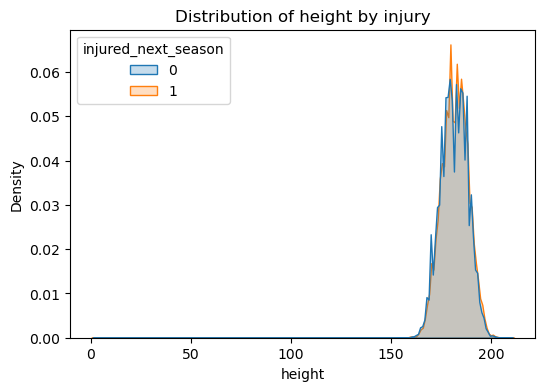

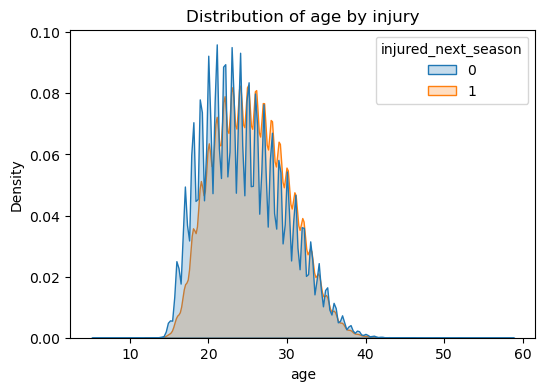

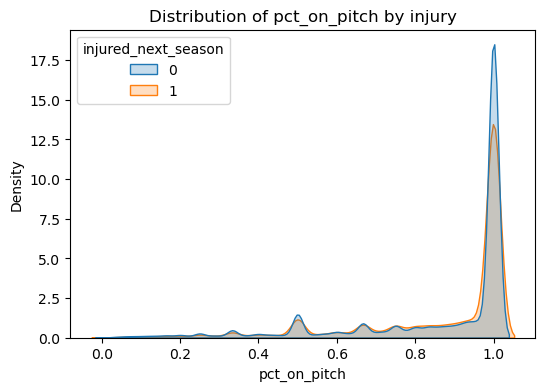

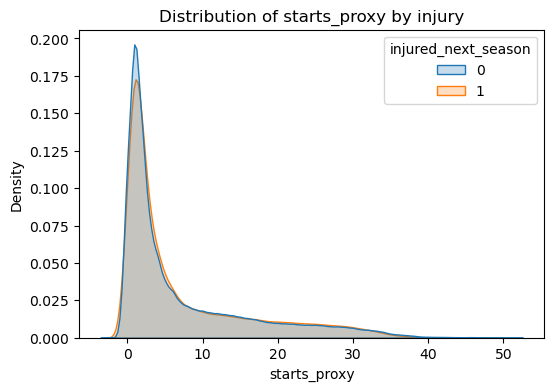

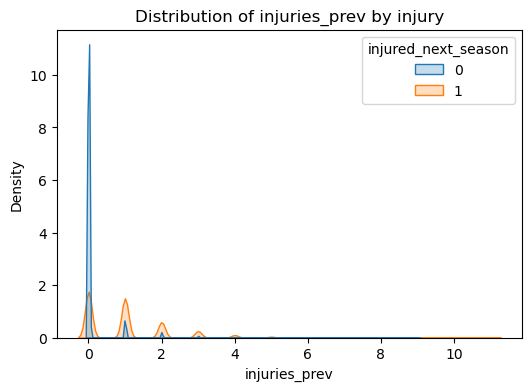

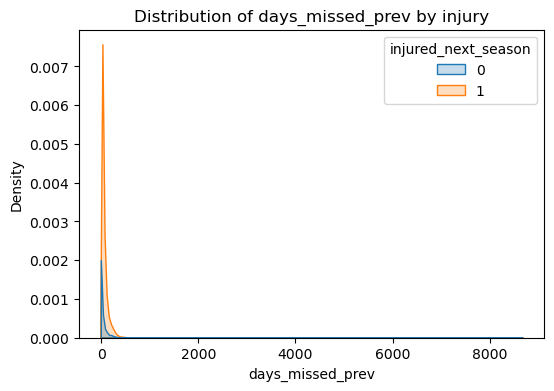

In [57]:
for col in numerical:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=model_df, x=col, hue=target, fill=True, common_norm=False)
    plt.title(f"Distribution of {col} by injury")
    plt.show()


In [58]:
corr = model_df[numerical + [target]].corr()[target].sort_values(ascending=False)
print(corr)

injured_next_season    1.000000
injuries_count         0.641907
injuries_prev          0.476376
total_days_missed      0.348225
days_missed_prev       0.250649
assists                0.070576
age                    0.062104
height                 0.031150
goals                  0.017147
yellow_cards           0.008407
pct_on_pitch           0.005131
nb_on_pitch            0.004118
starts_proxy           0.000251
Name: injured_next_season, dtype: float64


plt.figure(figsize=(12,8))
corr = model_df[numerical +[target]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center =0)
plt.title("Correlation Heatmap (Numerical Features + Target Variable)")
plt.show()

Strongest signals for injured_next_season

- Injuries_count → ~0.64 with the target. Biggest linear driver: players who had more injuries (this season) are much more likely to be injured next season.
- Days_missed_prev → ~0.48. Prior time loss is a solid predictor of future injury.
- Total_days_missed (current season) → ~0.35. More current-season time lost is associated with higher future risk.
- Injuries_prev → ~0.25. Past injury frequency still adds information, though less than time loss.

Features with little or no linear relationship to the target

- Playing/performance metrics: nb_on_pitch, starts_proxy, pct_on_pitch, goals, assists, yellow_cards → ~0 to very small correlations.
- Anthropometrics: height, and age → near zero.

On their own, these don’t correlate linearly with next‑season injury. They might still matter via interactions (e.g., workload × prior injury), but they’re weak as standalone predictors.

Notable collinearities (within predictors)

- nb_on_pitch ↔ starts_proxy → ~0.95 (very high)
- nb_on_pitch ↔ pct_on_pitch → ~0.71, starts_proxy ↔ pct_on_pitch → ~0.78. These are all “playing time” proxies. We will keep only pct_on_pitch to avoid multicollinearity.
- injuries_count ↔ total_days_missed → ~0.48 Both measure injury burden in different ways, we will keep them both
- days_missed_prev ↔ total_days_missed → ~0.63, injuries_prev ↔ days_missed_prev → ~0.52 Prior burden metrics are correlated (as expected). We will use regularization

#### Categorical EDA

injured_next_season         0         1
position_group                         
Attack               0.842597  0.157403
Defense              0.846964  0.153036
Goalkeeper           0.889401  0.110599
Midfield             0.856276  0.143724


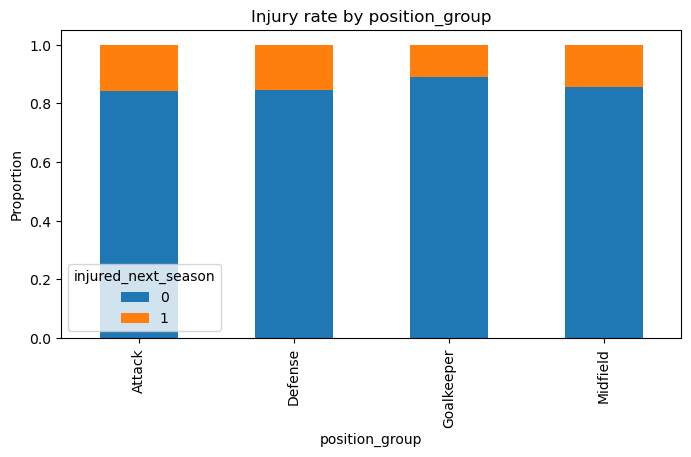

In [59]:
for col in categorical:
    ct = pd.crosstab(model_df[col], model_df[target], normalize='index')
    print(ct)
    ct.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(f"Injury rate by {col}")
    plt.ylabel("Proportion")
    plt.show()


In [60]:
from sklearn.metrics import mutual_info_score

In [61]:
mutual_info_score(model_df["position_group"], model_df[target])

0.0006365457821543088

#### Bivariate checks for interactions

C:\Users\Minmin.Yuan\AppData\Local\Temp\ipykernel_34292\1846636133.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap = model_df.groupby(['age_bin','pitch_bin'])['injured_next_season'].mean().unstack()


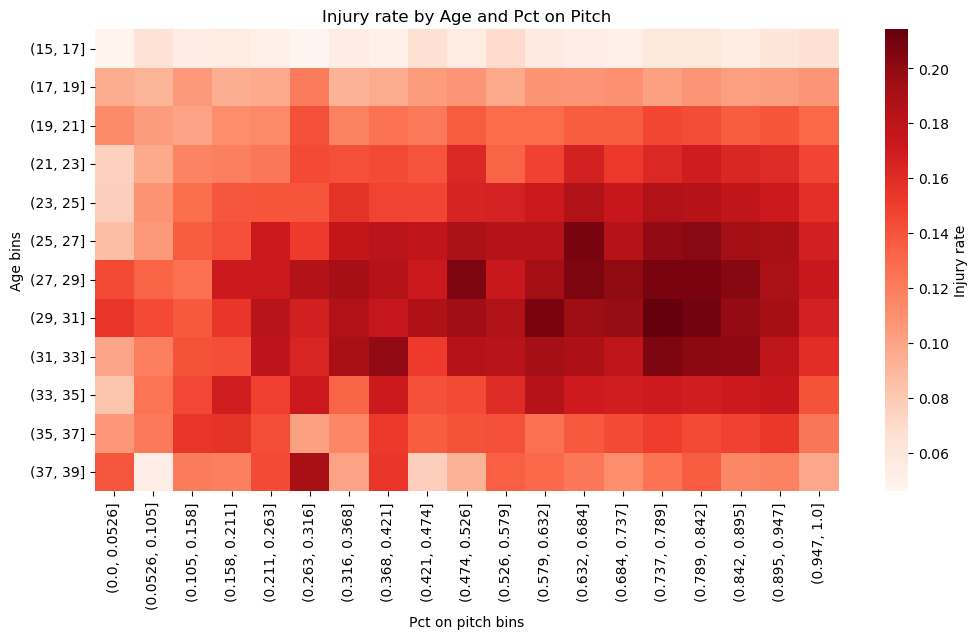

In [62]:
age_bins = np.arange(15, 40, 2)
pitch_bins = np.linspace(0, 1, 20)

# Compute injury rate in each bin
model_df['age_bin'] = pd.cut(model_df['age'], bins=age_bins)
model_df['pitch_bin'] = pd.cut(model_df['pct_on_pitch'], bins=pitch_bins)

heatmap = model_df.groupby(['age_bin','pitch_bin'])['injured_next_season'].mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(heatmap, cmap='Reds', cbar_kws={'label':'Injury rate'})
plt.title('Injury rate by Age and Pct on Pitch')
plt.xlabel('Pct on pitch bins')
plt.ylabel('Age bins')
plt.show()

There’s a hot zone (darkest reds) roughly around ages ~25–31 and pct_on_pitch ~0.47–0.68, with elevated risk also appearing for older players (33+) at moderate–high workloads.

In [63]:
model_df.drop(columns =["starts_proxy","nb_on_pitch"])

,season_id,goals,assists,yellow_cards,injuries_count,total_days_missed,height,age,pct_on_pitch,injuries_prev,days_missed_prev,injured_next_season,position_group,age_bin,pitch_bin
14,2000,1.0,2,0,0.0,0.0,177.0,20,0.428571,0.0,0.0,0,Attack,"(19, 21]","(0.421, 0.474]"
15,2000,15.0,0,0,0.0,0.0,177.0,20,1.000000,0.0,0.0,0,Attack,"(19, 21]","(0.947, 1.0]"
16,2000,0.0,0,0,0.0,0.0,177.0,20,0.100000,0.0,0.0,0,Attack,"(19, 21]","(0.0526, 0.105]"
17,2000,0.0,0,1,0.0,0.0,177.0,20,1.000000,0.0,0.0,0,Attack,"(19, 21]","(0.947, 1.0]"
12,2001,9.0,0,5,0.0,0.0,177.0,21,1.000000,0.0,0.0,0,Attack,"(19, 21]","(0.947, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201743,2025,0.0,0,0,0.0,0.0,177.0,18,1.000000,0.0,0.0,0,Attack,"(17, 19]","(0.947, 1.0]"
201792,2025,0.0,0,0,0.0,0.0,188.0,19,1.000000,0.0,0.0,0,Goalkeeper,"(17, 19]","(0.947, 1.0]"
201793,2025,0.0,0,0,0.0,0.0,180.0,17,1.000000,0.0,0.0,0,Defense,"(15, 17]","(0.947, 1.0]"
201861,2025,0.0,0,0,0.0,0.0,177.0,18,1.000000,0.0,0.0,0,Midfield,"(17, 19]","(0.947, 1.0]"


In [64]:
out_dir = "exports"
os.makedirs(out_dir, exist_ok=True)
model_df.to_csv(os.path.join(out_dir, "clean_data.csv"), index=False)

## Model

### Train Test Split (time-based)

In [65]:
model_df["season_id"].value_counts().sort_index()

season_id
2000     15326
2001     18019
2002     20252
2003     23446
2004     26407
2005     28971
2006     32051
2007     35693
2008     39800
2009     43903
2010     48178
2011     52540
2012     58444
2013     63843
2014     67697
2015     73311
2016     79271
2017     86160
2018     92539
2019     94948
2020     98621
2021    112614
2022    119271
2023    119469
2024    118266
2025     62262
Name: count, dtype: int64

Based on the value counts of season_id, We’ll use:

- Train: 2000–2018

- Validation: 2019–2021

- Test: 2022–2024

- Exclude: 2025 (incomplete)

- 

In [66]:
#Reorganize features after selection

num_features = ["age", "height", "pct_on_pitch",
    "goals", "assists", "yellow_cards",
    "injuries_count", "total_days_missed",
    "injuries_prev", "days_missed_prev"]

cat_features = ["position_group"]

feature_cols = num_features + cat_features

In [67]:
df_clean = model_df[model_df["season_id"] <= 2024].copy()

In [68]:
train_mask = df_clean["season_id"] <= 2018
val_mask   = (df_clean["season_id"] >= 2019) & (df_clean["season_id"] <= 2021)
test_mask  = df_clean["season_id"] >= 2022

In [69]:
df_train = df_clean[train_mask]
df_val = df_clean[val_mask]
df_test = df_clean[test_mask]

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

In [70]:
del df_train[target]
del df_val[target]
del df_test[target]

### One-hot Encoding

In [71]:
from sklearn.feature_extraction import DictVectorizer

In [72]:
dv = DictVectorizer(sparse = False)

In [73]:
train_dict = df_train[feature_cols].to_dict(orient = "records")
X_train = dv.fit_transform(train_dict)

val_dict = df_val[feature_cols].to_dict(orient = "records")
X_val = dv.transform(val_dict)

test_dict = df_test[feature_cols].to_dict(orient = "records")
X_test = dv.transform(test_dict)

### Model Training & Parameter Tuning

#### Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (average_precision_score, brier_score_loss, roc_auc_score)

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lr_pipeline = Pipeline(
    steps=[
        (
            "scaler",
            StandardScaler(with_mean=False)  
        ),
        (
            "clf",
            LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                l1_ratio=0.5,
                C=0.1,
                class_weight="balanced",
                max_iter=500,
                n_jobs=-1,
                random_state=42
            )
        )
    ]
)


In [76]:
lr_pipeline.fit(X_train, y_train)

C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,0.1


In [77]:
y_val_pred = lr_pipeline.predict(X_val)
y_val_prob = lr_pipeline.predict_proba(X_val)[:1]

In [78]:
pr_auc = average_precision_score(y_val, y_val_pred)
brier = brier_score_loss(y_val, y_val_pred)
roc = roc_auc_score(y_val, y_val_pred)

print("Average Precision Score", pr_auc)
print("Brier Score Loss", brier)
print("ROC-AUC", roc)

Average Precision Score 0.6656904538596404
Brier Score Loss 0.0892211520561233
ROC-AUC 0.8608248920027375


In [ ]:
C_values = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
l1_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

results = []

for C in C_values:
    for l1 in l1_ratios:

        lr_pipeline.set_params(
            clf__C=C,
            clf__l1_ratio=l1
        )

        lr_pipeline.fit(X_train, y_train)

        y_val_pred = lr_pipeline.predict_proba(X_val)[:, 1]

        results.append({
            "C": C,
            "l1_ratio": l1,
            "Average Precision Score": average_precision_score(y_val, y_val_pred),
            "Brier Score Loss": brier_score_loss(y_val, y_val_pred),
            "ROC-AUC": roc_auc_score(y_val, y_val_pred)
        })

results_df = pd.DataFrame(results).sort_values("Average Precision Score", ascending=False)
results_df.head(10)

C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which 

#### LightGBM

In [76]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 19.2 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [108]:
import lightgbm as lgb

lgb_pipeline = Pipeline([
    ("clf", lgb.LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])


In [109]:
lgb_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 107391, number of negative: 798460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 905851, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'binary'


In [110]:
y_val_pred = lgb_pipeline.predict(X_val)
y_val_prob = lgb_pipeline.predict_proba(X_val)[:1]

C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [111]:
pr_auc = average_precision_score(y_val, y_val_pred)
brier = brier_score_loss(y_val, y_val_pred)
roc = roc_auc_score(y_val, y_val_pred)

print("Average Precision Score", pr_auc)
print("Brier Score Loss", brier)
print("ROC-AUC", roc)

Average Precision Score 0.6654187310979177
Brier Score Loss 0.0893126006342612
ROC-AUC 0.8607781861591366


In [112]:
# --- Parameter grid for iterative tuning ---
param_grid = [
    {
        "clf__num_leaves": 31,
        "clf__max_depth": -1,
        "clf__learning_rate": 0.05,
        "clf__n_estimators": 300,
        "clf__subsample": 0.8,
        "clf__colsample_bytree": 0.8,
        "clf__reg_alpha": 0.1,
        "clf__reg_lambda": 0.1
    },
    {
        "clf__num_leaves": 50,
        "clf__max_depth": 20,
        "clf__learning_rate": 0.05,
        "clf__n_estimators": 300,
        "clf__subsample": 0.8,
        "clf__colsample_bytree": 0.8,
        "clf__reg_alpha": 0.1,
        "clf__reg_lambda": 0.1
    },
    {
        "clf__num_leaves": 70,
        "clf__max_depth": 30,
        "clf__learning_rate": 0.01,
        "clf__n_estimators": 500,
        "clf__subsample": 0.7,
        "clf__colsample_bytree": 0.7,
        "clf__reg_alpha": 0.1,
        "clf__reg_lambda": 0.1
    }
]

best_pr_auc = 0
best_params = None

for params in param_grid:
    
    lgb_pipeline.set_params(**params)
    
    lgb_pipeline.fit(
        X_train, y_train
    )
    
    y_val_pred = lgb_pipeline.predict_proba(X_val)[:, 1]
    
    # Evaluate metrics
    pr_auc = average_precision_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred)
    brier = brier_score_loss(y_val, y_val_pred)
    
    print(f"Params: {params}")
    print(f"PR-AUC: {pr_auc:.4f}, ROC-AUC: {roc_auc:.4f}, Brier: {brier:.4f}\n")
    
    # Track best PR-AUC
    if pr_auc > best_pr_auc:
        best_pr_auc = pr_auc
        best_params = params

print("Best params:", best_params)


[LightGBM] [Info] Number of positive: 107391, number of negative: 798460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 905851, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Params: {'clf__num_leaves': 31, 'clf__max_depth': -1, 'clf__learning_rate': 0.05, 'clf__n_estimators': 300, 'clf__subsample': 0.8, 'clf__colsample_bytree': 0.8, 'clf__reg_alpha': 0.1, 'clf__reg_lambda': 0.1}
PR-AUC: 0.7872, ROC-AUC: 0.8931, Brier: 0.1008

[LightGBM] [Info] Number of positive: 107391, number of negative: 798460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 905851, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Params: {'clf__num_leaves': 50, 'clf__max_depth': 20, 'clf__learning_rate': 0.05, 'clf__n_estimators': 300, 'clf__subsample': 0.8, 'clf__colsample_bytree': 0.8, 'clf__reg_alpha': 0.1, 'clf__reg_lambda': 0.1}
PR-AUC: 0.7881, ROC-AUC: 0.8932, Brier: 0.1007

[LightGBM] [Info] Number of positive: 107391, number of negative: 798460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 905851, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Params: {'clf__num_leaves': 70, 'clf__max_depth': 30, 'clf__learning_rate': 0.01, 'clf__n_estimators': 500, 'clf__subsample': 0.7, 'clf__colsample_bytree': 0.7, 'clf__reg_alpha': 0.1, 'clf__reg_lambda': 0.1}
PR-AUC: 0.7840, ROC-AUC: 0.8932, Brier: 0.1011

Best params: {'clf__num_leaves': 50, 'clf__max_depth': 20, 'clf__learning_rate': 0.05, 'clf__n_estimators': 300, 'clf__subsample': 0.8, 'clf__colsample_bytree': 0.8, 'clf__reg_alpha': 0.1, 'clf__reg_lambda': 0.1}


#### Neural Network

In [88]:
scaler = StandardScaler(with_mean=False) 
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

def to_tensor(X, y):
    if hasattr(X, "toarray"):  # scipy sparse
        X = X.toarray()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor


In [92]:
def make_loaders(X_train, y_train, X_val, y_val, batch_size):
    X_tr, y_tr = to_tensor(X_train, y_train)
    X_va, y_va = to_tensor(X_val, y_val)

    train_loader = DataLoader(
        TensorDataset(X_tr, y_tr),
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        TensorDataset(X_va, y_va),
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader

In [93]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout):
        super().__init__()
        layers = []
        prev = input_dim

        for h in hidden_layers:
            layers.extend([
                nn.Linear(prev, h),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev = h

        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.net(x))


In [94]:
import torch.nn.functional as F

def make_weighted_bce(y_train):
    pos = y_train.sum()
    neg = len(y_train) - pos
    pos_weight = neg / pos
    return nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))


In [95]:
def train_model(
    X_train, y_train,
    X_val, y_val,
    hidden_layers,
    dropout,
    lr,
    batch_size,
    epochs=20
):
    train_loader, val_loader = make_loaders(
        X_train, y_train, X_val, y_val, batch_size
    )

    input_dim = train_loader.dataset.tensors[0].shape[1]
    model = MLP(input_dim, hidden_layers, dropout)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = make_weighted_bce(y_train)

    for epoch in range(epochs):
        # ---- Train ----
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model.net(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # ---- Validate ----
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                prob = torch.sigmoid(model.net(xb))
                preds.append(prob.numpy())
                targets.append(yb.numpy())

        preds = np.vstack(preds)
        targets = np.vstack(targets)

        pr_auc = average_precision_score(targets, preds)
        roc_auc = roc_auc_score(targets, preds)
        brier = brier_score_loss(targets, preds)

        print(
            f"Epoch {epoch+1:02d} | "
            f"PR-AUC: {pr_auc:.4f} | "
            f"ROC-AUC: {roc_auc:.4f} | "
            f"Brier: {brier:.4f}"
        )

    return model, pr_auc, roc_auc, brier

In [96]:
# Chosen hyperparameters 
hidden_layers = [128, 64]
dropout = 0.3
learning_rate = 0.001
batch_size = 1024
epochs = 20

model, pr_auc, roc_auc, brier = train_model(
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    hidden_layers=hidden_layers,
    dropout=dropout,
    lr=learning_rate,
    batch_size=batch_size,
    epochs=epochs
)

print("Final validation metrics:")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Brier: {brier:.4f}")


Epoch 01 | PR-AUC: 0.7575 | ROC-AUC: 0.8789 | Brier: 0.1043
Epoch 02 | PR-AUC: 0.7683 | ROC-AUC: 0.8832 | Brier: 0.1068
Epoch 03 | PR-AUC: 0.7713 | ROC-AUC: 0.8843 | Brier: 0.0984
Epoch 04 | PR-AUC: 0.7742 | ROC-AUC: 0.8860 | Brier: 0.1012
Epoch 05 | PR-AUC: 0.7754 | ROC-AUC: 0.8861 | Brier: 0.1044
Epoch 06 | PR-AUC: 0.7777 | ROC-AUC: 0.8872 | Brier: 0.0984
Epoch 07 | PR-AUC: 0.7761 | ROC-AUC: 0.8872 | Brier: 0.1024
Epoch 08 | PR-AUC: 0.7799 | ROC-AUC: 0.8881 | Brier: 0.1042
Epoch 09 | PR-AUC: 0.7789 | ROC-AUC: 0.8871 | Brier: 0.0963
Epoch 10 | PR-AUC: 0.7805 | ROC-AUC: 0.8881 | Brier: 0.1041
Epoch 11 | PR-AUC: 0.7801 | ROC-AUC: 0.8884 | Brier: 0.0983
Epoch 12 | PR-AUC: 0.7807 | ROC-AUC: 0.8883 | Brier: 0.1022
Epoch 13 | PR-AUC: 0.7814 | ROC-AUC: 0.8888 | Brier: 0.0992
Epoch 14 | PR-AUC: 0.7812 | ROC-AUC: 0.8884 | Brier: 0.1037
Epoch 15 | PR-AUC: 0.7815 | ROC-AUC: 0.8883 | Brier: 0.0986
Epoch 16 | PR-AUC: 0.7819 | ROC-AUC: 0.8881 | Brier: 0.1057
Epoch 17 | PR-AUC: 0.7814 | ROC-AUC: 0.8

#### Model Selection

| Model                                | Tuned?   | PR-AUC (↑) | ROC-AUC (↑) | Brier Score (↓) |
| ------------------------------------ | -------- | ---------- | ----------- | --------------- |
| **Logistic Regression (ElasticNet)** | ❌ No     | **0.6657** | **0.8608**  | **0.0892**      |
| **Neural Network (MLP)**             | ⚠️ Light | **0.7809** | **0.8884**  | **0.0998**      |
| **LightGBM (GBDT)**                  | ✅ Yes    | **0.7881** | **0.8932**  | **0.1007**      |


Conclusion:
- We evaluated Logistic Regression, a neural network, and LightGBM using temporal validation by season. Logistic Regression, while well calibrated, showed substantially weaker discrimination.
- The neural network improved performance, but LightGBM achieved the best overall predictive quality, particularly in precision-recall space, which is critical for imbalanced injury prediction. Therefore, LightGBM was selected as the primary model

### Export & Load Model (LightGMB)

In [101]:
import pickle

In [113]:
best_params = {
    'num_leaves': 50,
    'max_depth': 20,
    'learning_rate': 0.05,
    'n_estimators': 300,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'objective': 'binary',
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1
}

lgb_model = Pipeline([
    ("clf", lgb.LGBMClassifier(**best_params))
])

In [114]:
with open ("lgb_model.pkl","wb") as file:
    pickle.dump({
        "vectorizer":dv,
        "model":lgb_pipeline
    }, file)
print("Full Light GBM model saved successfully")

Full Light GBM model saved successfully


In [115]:
with open("lgb_model.pkl","rb") as file:
     artifacts = pickle.load(file)

dv = artifacts["vectorizer"]
model = artifacts["model"]

In [104]:
player_sample = {
    "goals": 6,
    "assists": 4,
    "yellow_cards": 3,
    "injuries_count": 1,
    "total_days_missed": 18,
    "height": 182,
    "age": 26,
    "pct_on_pitch": 0.78,
    "injuries_prev": 2,
    "days_missed_prev": 42,
    "position_group": "MIDFIELDER"
}

In [116]:
X_sample = dv.transform([player_sample])
injury_prob = lgb_pipeline.predict_proba(X_sample)[:, 1][0]
print(f"Injury risk next season: {injury_prob:.3f}")

Injury risk next season: 0.984


C:\Users\Minmin.Yuan\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
